<a href="https://colab.research.google.com/github/Malmasre/Arabic-ACD/blob/main/3_ARABERT_Teacher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step1: Teacher Model

In [ ]:
# !pip install -U plotly
# !pip install pyyaml==5.4.1
# !pip install ktrain
# !pip install git+https://github.com/amaiya/eli5@tfkeras_0_10_1
# !pip install git+https://github.com/amaiya/stellargraph@no_tf_dep_082

**Restart immediately after running the above cell**

# Imports and Preparation

In [ ]:
#allows us to create the Data and Figure objects
from plotly.graph_objs import *
#plotly.plotly pushes your charts to the cloud  
# import chart_studio.plotly as py
# import plotly.figure_factory as ff
import plotly.express as px
# import chart_studio.plotly as py

import matplotlib.pyplot as plt
%matplotlib inline

# work with cufflinks offline and set its theme
import plotly.io as pio
pio.templates.default = "plotly_white"
from plotly.subplots import make_subplots



import pandas as pd
import numpy as np

# from utils import *

import os
import json
import re
import sys

In [ ]:
import ktrain
from ktrain import text

In [ ]:
def plot_conf_matrix(conf_matrix_array, class_names, title='', normalized = False, colorscale='GnBu'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`
    """

    z_vals = conf_matrix_array[::-1]
    
    title = 'Confusion Matrix<br>{0}'.format(title)
    
    if normalized:
        z_vals =  np.round(z_vals.astype('float')/z_vals.sum(axis=1)[:, np.newaxis], 3)
        title = 'Normalized ' + title
        
    fig = ff.create_annotated_heatmap(x = class_names,
                                      y = class_names[::-1],
                                      z = z_vals, colorscale=colorscale, showscale=True)
    
    
    
    fig.layout.update(title = title,
                      width=700, height=500,
                      yaxis = dict(title = 'True', side = 'left'),
                      xaxis = dict(title = 'Predicted', side = 'bottom'))
    return fig

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
from sklearn.metrics import confusion_matrix as cm, classification_report as cr

metrics_map = {
    'Accuracy': accuracy_score,
    'Precision': precision_score,
    'Recall': recall_score,
    'F1-score': f1_score,
    'Logloss': log_loss
}

In [ ]:
def train_val_test_split(X, y, test_size, val_size, random_state, stratify):
    '''split a multi-labeled data into train, validation, and test sets using'''
    
    X_train, X_val_test, y_train, y_val_test = train_test_split(X, y,
                                                                test_size=val_size+test_size,
                                                                random_state=random_state,
                                                                stratify=stratify)
    
    
    
    X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test,
                                                    test_size=0.5,
                                                    random_state=random_state,
                                                    stratify=y_val_test)
    
    
    
    return X_train, X_val, X_test, y_train, y_val, y_test
    

In [ ]:
import tensorflow as tf
print(tf.__version__)
# # print(tf.test.gpu_device_name())
# # print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.8.0


In [ ]:
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.optimizers import Adam

In [ ]:
def print_full(x):
    pd.set_option('display.max_colwidth', None)
    return x

def reset():
    pd.reset_option('display.max_colwidth')

## Reading The Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PROJECT_PATH = '/content/drive/My Drive/colab/zeroshot-ar/'
DATA_PATH= '/content/drive/My Drive/colab/zeroshot-ar/data/semEval'
FILE_PATH = os.path.join(DATA_PATH, 'semeval_clean.json')
RES_PATH = os.path.join(PROJECT_PATH, 'result')
# FILE_PATH_AUG = os.path.join(DATA_PATH, 'semeval_clean_aug_aspect_terms.json')
MODEL_PATH='/content/drive/My Drive/colab/zeroshot-ar/models/bert-multilabel-semEval'

if not os.path.isdir(MODEL_PATH):
  os.makedirs(MODEL_PATH)

if not os.path.isdir(PROJECT_PATH):
  os.makedirs(PROJECT_PATH)

if not os.path.isdir(RES_PATH):
  os.makedirs(RES_PATH)

In [ ]:
RES_PATH

'/content/drive/My Drive/colab/zeroshot-ar/result'

In [ ]:
df = pd.read_json(FILE_PATH)

In [ ]:
df.head(1)

,text,terms,fine_aspects,polarity,split,coarse_aspects,text_lemma
0,أنصح بالنوم وليس تناول الطعام موقع مثالي للإق...,[موقع],[LOCATION#GENERAL],[positive],Train,[LOCATION],انصح بالنوم ليس تناول الطعام موقع مثالي للاقام...


In [ ]:
import json
UNIQUE_ASPECTS_PATH = f'{DATA_PATH}/fine_aspects.txt'
with open(UNIQUE_ASPECTS_PATH, 'r') as f:
    unique_aspects = json.loads(f.read())

In [ ]:
features = 'text'
features_lemma = 'text_lemma'
# features_lemma = 'combined_features'
target = 'fine_aspects'
classes = unique_aspects

In [ ]:
# import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, roc_auc_score
from sklearn.metrics import confusion_matrix as cm, classification_report as cr

metrics_dict =  {'Accuracy': accuracy_score,
                 'Precision': precision_score,
                 'Recall': recall_score,
                 'F1-score': f1_score,
                 'Logloss': log_loss,
                 'AUC': roc_auc_score}

In [ ]:
# classes = sorted(df[target].unique())
# def pretty_cm(y_true, y_pred, classes=classes, normalized=True):
#     # if y_true is one-hot-encoded --> collapse it 
#     y_true = y_true.argmax(axis=1) if len(y_true.shape) > 1 else y_true
    
#     confusion_mtx = cm(y_true, y_pred)
#     cm_df = pd.DataFrame(confusion_mtx, index=classes, columns=classes)
    
#     if normalized:
#         cm_df = cm_df.apply(lambda row: row/row.sum(), axis=1).round(4)
#     return cm_df

In [ ]:
def pretty_cr(y_true, y_pred, classes=classes):
    # if y_true is one-hot-encoded --> collapse it 
    y_true = y_true.argmax(axis=1) if len(y_true.shape) > 1 else y_true
    report = cr(y_true, y_pred, output_dict=True, target_names=classes)
    cr_df = pd.DataFrame(report).transpose()
    
    # support is just the number of samples in each class
    cr_df['support'] = cr_df['support'].astype('int')
    
    # accuracy has no micro or macro averaging!
    cr_df.loc['accuracy', ['precision', 'recall']] = ""
    cr_df.loc['accuracy', ['support']] = len(y_true)
    
    # remove the accuracy row to the end
    acc_row = cr_df.loc['accuracy']
    cr_df.drop('accuracy', axis=0, inplace=True)
    cr_df = cr_df.append(acc_row)
    
    return cr_df

In [ ]:
def multilabel_sample(y, size=1000, min_count=5, seed=None):
    """ Takes a matrix of binary labels `y` and returns
        the indices for a sample of size `size` if
        `size` > 1 or `size` * len(y) if size =< 1.

        The sample is guaranteed to have > `min_count` of
        each label.
    """
    try:
        if (np.unique(y).astype(int) != np.array([0, 1])).all():
            raise ValueError()
    except (TypeError, ValueError):
        raise ValueError('multilabel_sample only works with binary indicator matrices')

    if (y.sum(axis=0) < min_count).any():
        raise ValueError('Some classes do not have enough examples. Change min_count if necessary.')

    if size <= 1:
        size = np.floor(y.shape[0] * size)

    if y.shape[1] * min_count > size:
        msg = "Size less than number of columns * min_count, returning {} items instead of {}."
        warnings.warn(msg.format(y.shape[1] * min_count, size))
        size = y.shape[1] * min_count

    rng = np.random.RandomState(seed if seed is not None else np.random.randint(1))

    if isinstance(y, pd.DataFrame):
        choices = y.index
        y = y.values
    else:
        choices = np.arange(y.shape[0])

    sample_idxs = np.array([], dtype=choices.dtype)

    # first, guarantee > min_count of each label
    for j in range(y.shape[1]):
        label_choices = choices[y[:, j] == 1]
        label_idxs_sampled = rng.choice(label_choices, size=min_count, replace=False)
        sample_idxs = np.concatenate([label_idxs_sampled, sample_idxs])

    sample_idxs = np.unique(sample_idxs)

    # now that we have at least min_count of each, we can just random sample
    sample_count = int(size - sample_idxs.shape[0])

    # get sample_count indices from remaining choices
    remaining_choices = np.setdiff1d(choices, sample_idxs)
    remaining_sampled = rng.choice(remaining_choices,
                                   size=sample_count,
                                   replace=False)

    return np.concatenate([sample_idxs, remaining_sampled])


def multilabel_sample_dataframe(df, labels, size, min_count=5, seed=None):
    """ Takes a dataframe `df` and returns a sample of size `size` where all
        classes in the binary matrix `labels` are represented at
        least `min_count` times.
    """
    idxs = multilabel_sample(labels, size=size, min_count=min_count, seed=seed)
    return df.loc[idxs]


def multilabel_train_test_split(X, Y, size, min_count=5, seed=None):
    """ Takes a features matrix `X` and a label matrix `Y` and
        returns (X_train, X_test, Y_train, Y_test) where all
        classes in Y are represented at least `min_count` times.
    """
    index = Y.index if isinstance(Y, pd.DataFrame) else np.arange(Y.shape[0])

    test_set_idxs = multilabel_sample(Y, size=size, min_count=min_count, seed=seed)
    train_set_idxs = np.setdiff1d(index, test_set_idxs)

    test_set_mask = index.isin(test_set_idxs)
    train_set_mask = ~test_set_mask

    return (X[train_set_mask], X[test_set_mask], Y[train_set_mask], Y[test_set_mask])

In [ ]:
# X, y = df.loc[df['split'] == 'Train', features_lemma].values, df.loc[df['split'] == 'Train', target].values

In [ ]:
# df = df.loc[df['split'] == 'Train']

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

# Convert the multi-labels into arrays
mlb = MultiLabelBinarizer()


In [ ]:
X_train, y_train = df.loc[df['split'] == 'Train', features_lemma].values, df.loc[df['split'] == 'Train', target].values

In [ ]:
X_test, y_test = df.loc[df['split'] == 'Test', features_lemma].values, df.loc[df['split'] == 'Test', target].values

In [ ]:
y_train, y_test = mlb.fit_transform(y_train), mlb.fit_transform(y_test)

In [ ]:
y_train.shape, y_test.shape

((4802, 34), (1227, 34))

In [ ]:
mlb.classes_

array(['FACILITIES#CLEANLINESS', 'FACILITIES#COMFORT',
       'FACILITIES#DESIGN_FEATURES', 'FACILITIES#GENERAL',
       'FACILITIES#MISCELLANEOUS', 'FACILITIES#PRICES',
       'FACILITIES#QUALITY', 'FOOD_DRINKS#MISCELLANEOUS',
       'FOOD_DRINKS#PRICES', 'FOOD_DRINKS#QUALITY',
       'FOOD_DRINKS#STYLE_OPTIONS', 'HOTEL#CLEANLINESS', 'HOTEL#COMFORT',
       'HOTEL#DESIGN_FEATURES', 'HOTEL#GENERAL', 'HOTEL#MISCELLANEOUS',
       'HOTEL#PRICES', 'HOTEL#QUALITY', 'LOCATION#GENERAL',
       'ROOMS#CLEANLINESS', 'ROOMS#COMFORT', 'ROOMS#DESIGN_FEATURES',
       'ROOMS#GENERAL', 'ROOMS#MISCELLANEOUS', 'ROOMS#PRICES',
       'ROOMS#QUALITY', 'ROOMS_AMENITIES#CLEANLINESS',
       'ROOMS_AMENITIES#COMFORT', 'ROOMS_AMENITIES#DESIGN_FEATURES',
       'ROOMS_AMENITIES#GENERAL', 'ROOMS_AMENITIES#MISCELLANEOUS',
       'ROOMS_AMENITIES#PRICES', 'ROOMS_AMENITIES#QUALITY',
       'SERVICE#GENERAL'], dtype=object)

## How to Tkenize, Preprocess and prepare Text Using BERT Tokenizer

[Huggingface Models](https://huggingface.co/models)

In [ ]:
# choose the max_len of the sequence
(df[features_lemma].apply(lambda review: len(review.split())).quantile(1.0))  

86.0

In [ ]:
# choose the pretrained model we'll work with
MODEL_NAME = 'aubmindlab/bert-base-arabertv02'
# MODEL_NAME = 'bashar-talafha/multi-dialect-bert-base-arabic'
MAX_LEN = 86
BS = 32

In [ ]:
preproc = text.Transformer(MODEL_NAME, maxlen=MAX_LEN, batch_size=BS,
                           class_names=mlb.classes_)

Downloading:   0%|          | 0.00/384 [00:00<?, ?B/s]

In [ ]:
MAX_FEATURES = preproc.get_tokenizer().vocab_size
MAX_FEATURES

Downloading:   0%|          | 0.00/381 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/825k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.64M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

64000

In [ ]:
sample_text = df[features_lemma].iloc[0]
sample_tokenized = preproc.get_tokenizer().tokenize(sample_text)
sample_tokenized  # word-piece embedding

['انص',
 '##ح',
 'بالن',
 '##وم',
 'ليس',
 'تناول',
 'الطعام',
 'موقع',
 'مثالي',
 'للاق',
 '##امه',
 'قبل',
 'رحل',
 '##ه',
 'طيران',
 'مبكر',
 '##ه']

In [ ]:
%%time
# preprocess train data
trn = preproc.preprocess_train(X_train, y_train)

preprocessing train...
language: ar
train sequence lengths:
	mean : 21
	95percentile : 50
	99percentile : 65


Is Multi-Label? True
CPU times: user 1.34 s, sys: 56.5 ms, total: 1.39 s
Wall time: 1.4 s


Example of how BERT tokenization works:

In [ ]:
X_train[4]

'ساوصي بالتاكيد بموقع المدينه القديمه الا انه عليك الحذر من الاسعار السياحيه الاكثر ارتفاعا'

In [ ]:
" ".join(preproc.undo(trn.x[0][0]))

'[CLS] انص ##ح بالن ##وم ليس تناول الطعام موقع مثالي للاق ##امه قبل رحل ##ه طيران مبكر ##ه [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [ ]:
test = preproc.preprocess_test(X_test, y_test)

preprocessing test...
language: ar
test sequence lengths:
	mean : 20
	95percentile : 50
	99percentile : 64


#### Extracting the Classifyer

Transformer models are multitask learners. We just need the classifier part of it, so we extract it and store it in a variable `model`

Then To use ktrain, one simply wraps the `model` and the data in a `Learner` object using the `get_learner` function. This Learner object will be used to help tune and train our network.

In [ ]:
model = preproc.get_classifier()

Downloading:   0%|          | 0.00/742M [00:00<?, ?B/s]

In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  135193344 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  26146     
                                                                 
Total params: 135,219,490
Trainable params: 135,219,490
Non-trainable params: 0
_________________________________________________________________


In [ ]:
learner = ktrain.get_learner(model, train_data=trn, val_data=test, batch_size=BS)

### A Learning Rate Finder

The Learner object can be used to find the best learning rate for your model.  First, we use ```lr_find``` to track the loss as the learning rate is increased and then use ```lr_plot``` to identify the maximal learning rate associated with a falling loss.

In [ ]:
learner.lr_find(stop_factor=2, max_epochs=10)

simulating training for different learning rates... this may take a few moments...
Epoch 1/10
120/120 [==============================] - 65s 363ms/step - loss: 0.6913 - accuracy: 0.0201
Epoch 2/10
120/120 [==============================] - 44s 368ms/step - loss: 0.5606 - accuracy: 0.0357
Epoch 3/10
120/120 [==============================] - 44s 365ms/step - loss: 0.3239 - accuracy: 0.1255
Epoch 4/10
120/120 [==============================] - 44s 366ms/step - loss: 0.1972 - accuracy: 0.1514
Epoch 5/10
120/120 [==============================] - 44s 371ms/step - loss: 0.1451 - accuracy: 0.3268
Epoch 6/10
120/120 [==============================] - 44s 365ms/step - loss: 0.1763 - accuracy: 0.1661
Epoch 7/10
120/120 [==============================] - 44s 365ms/step - loss: 0.2546 - accuracy: 0.1115
Epoch 8/10
120/120 [==============================] - 5s 37ms/step - loss: 0.7585 - accuracy: 0.1271


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help id

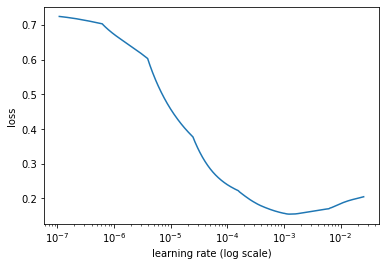

In [ ]:
learner.lr_plot(5, 40)

## Training with Learning Rate Schedules

This is from Ktrain Docs:

Varying the learning rate cyclically during training has been shown to be [effective](https://arxiv.org/abs/1506.01186) and a good general practice.  *ktrain* allows you to easily employ a variety of demonstrably effective learning rate policies during training. These include:

* a [triangular learning rate policy](https://arxiv.org/abs/1506.01186) available via the ```autofit``` method
* a [1cycle policy](https://arxiv.org/abs/1803.09820) available via the ```fit_onecycle``` method
* an [SGDR](https://arxiv.org/abs/1608.03983) (Stochastic Gradient Descent with Restart) schedule available using the ```fit``` method by supplying a *cycle_len* argument.

The ```autofit``` and ```fit_onecycle``` methods tend to be good choices that produce pleasing results.  For more information on learning rate schedules, see the [*ktrain* tutorial notebook on tuning learning rates](https://github.com/amaiya/ktrain/blob/master/tutorials/tutorial-02-tuning-learning-rates.ipynb).

The ```autofit``` method in *ktrain* employs a triangular learning rate schedule and uses the supplied learning rate as the maximum learning rate.  The ```autofit``` method accepts two primary arguments. The first (required) is the learning rate (**lr**) to be used, which can be found using the learning rate finder above. The second is optional and indicates the number of epochs (**epochs**) to train.  If **epochs** is not supplied as a second argument, then ```autofit``` will train until the validation loss no longer improves after a certain period. This period can be configured using the **early_stopping** argument.  The ```autofit``` method will also reduce the learning rate when validation loss no longer improves, which can be configured using the reduce_on_plateau argument to ```autofit```.  At the end of training, the weights producing the lowest validation loss are automatically loaded into the model.


The ```autofit``` method also accepts a **checkpoint_folder** argument representing the path to a directory. If supplied, the weights of the model after each epoch will be saved to this folder.  Thus, the model state of any epoch can be easily restored using the ```learner.model.load_weights``` method, if the final validation accuracy is not desired. In this case, the final accuracy is quite satisfactory for this model.  

see explanation here: https://course.fast.ai/videos/?lesson=3, at 1:19:35

And this paper as well:
https://papers.nips.cc/paper/7875-visualizing-the-loss-landscape-of-neural-nets.pdf

#### Using Autofit

Finally, we invoke autofit without supplying the number of epochs. As mentioned, the training will automatically stop when the validation loss fails to improve. Moreover, the maximum learning rate will automatically decrease periodically. We supply the checkpoint_folder argument to ensure we can restore the weights from any epoch after training completes.

The ```autofit``` method in *ktrain* employs a default cyclical learning rate schedule that tends to work well in practice.  The default learning rate schedule in ```autofit``` is currently the [triangular learning rate policy](https://arxiv.org/abs/1506.01186), which some slight modifications.

#### Setting Global Weight Decay in Keras

[Weight decay](https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-learning-with-weight-regularization/) is a form of regularization to reduce overfitting.  In Keras, this is typically done by [setting the weight decay for individual layers within the network](https://github.com/keras-team/keras/issues/2717).  The global weight decay for a neural model can easily be set by the ```learner.set_weight_decay``` method.    


In [ ]:
# # rebuild the model to train from scratch 
# rebuild the model to train from scratch 
learner.set_model(preproc.get_classifier())
learner.set_weight_decay(0.005)

/usr/local/lib/python3.7/dist-packages/ktrain/core.py:377: UserWarning: recompiling model to use AdamWeightDecay as opimizer with weight decay of 0.005
  warnings.warn('recompiling model to use AdamWeightDecay as opimizer with weight decay of %s' % (wd) )


In [ ]:
%%time
# trainin on the full training data
learner.autofit(1e-4, epochs=10, checkpoint_folder=MODEL_PATH)



begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/10
151/151 [==============================] - 92s 457ms/step - loss: 0.2536 - accuracy: 0.1097 - val_loss: 0.1691 - val_accuracy: 0.1304
Epoch 2/10
151/151 [==============================] - 68s 438ms/step - loss: 0.1592 - accuracy: 0.2520 - val_loss: 0.1367 - val_accuracy: 0.3651
Epoch 3/10
151/151 [==============================] - 77s 501ms/step - loss: 0.1316 - accuracy: 0.3651 - val_loss: 0.1188 - val_accuracy: 0.4075
Epoch 4/10
151/151 [==============================] - 72s 466ms/step - loss: 0.1138 - accuracy: 0.4088 - val_loss: 0.1100 - val_accuracy: 0.4042
Epoch 5/10
151/151 [==============================] - 73s 474ms/step - loss: 0.1007 - accuracy: 0.4419 - val_loss: 0.1034 - val_accuracy: 0.4165
Epoch 6/10
151/151 [==============================] - 75s 488ms/step - loss: 0.0890 - accuracy: 0.4875 - val_loss: 0.0993 - val_accuracy: 0.4319
Epoch 7/10
151/151 [==============================

In [ ]:
hist = learner.history.history
get_best_epoch = lambda metric: np.argmax(hist[metric]) + 1 if metric=='val_accuracy' else np.argmin(hist[metric])+1

best = get_best_epoch('val_loss'); best

9

In [ ]:
learner.model.load_weights(f'{MODEL_PATH}/weights-{9:02d}.hdf5')

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=preproc)

In [ ]:
predictor.save(f'{MODEL_PATH}/predictor.hd5')

In [ ]:
predictor = ktrain.load_predictor(f'{MODEL_PATH}/predictor.hd5')

## Testing on the Gold Standard Data Set

In [ ]:
def class_predict(learner, test_data, raw_test_data, thresh=0.5, drop_thresh=0.0):
    preds_proba = pd.DataFrame(learner.predict(test_data), columns=mlb.classes_)
    # replace rows under the drop_threshh with nans
    preds_proba = preds_proba.apply(lambda row: row if row.max() >= drop_thresh else row.apply(lambda x: np.nan), axis=1)
    # get the indices of those rows
    # r = np.asarray(preds_proba).nonzero()[0]
    r, _ = np.where(preds_proba.isna())
    drop_indices = list(set(r))
    # print(drop_indices)
    preds_proba = preds_proba.drop(drop_indices).reset_index(drop=True)
    # return the filtered raw test data
    raw_test_data = pd.DataFrame(raw_test_data).drop(drop_indices).reset_index(drop=True).values

    preds_classes = preds_proba.apply(lambda row: row.apply(lambda x: 1 if x > thresh else 0), axis=1).values
    # return preds_proba, drop_indices
    return preds_classes, raw_test_data


In [ ]:
%%time
preds_test, y_test_filtered = class_predict(learner, test, y_test, thresh=0.5, drop_thresh=0.0)

CPU times: user 8.36 s, sys: 351 ms, total: 8.71 s
Wall time: 11.7 s


In [ ]:
len(preds_test), len(y_test_filtered), len(y_test)

(1227, 1227, 1227)

In [ ]:
f1_score(y_test_filtered, preds_test, average='micro', zero_division=1)

0.6723591119785314

In [ ]:
def by_class_res(y_true, preds, plot=True, cor=False, model_name=None):
    res = (
        df.loc[df['split'] == 'Train', 'fine_aspects']
        .explode()
        .value_counts()
        .reset_index()
        # .pipe(lambda df: df.assign(index = df['index'].str.lower()))
        .sort_values('index')
    )

    res['f1-score'] = f1_score(y_true, preds, average=None)

    res = res.sort_values('fine_aspects', ascending=True)

    if cor:
        res = res[['fine_aspects', 'f1-score']].corr().loc['fine_aspects', ['f1-score']].values

    if plot and not cor:
        subfig = make_subplots(specs=[[{"secondary_y": True}]])
        fig1 = (
            res
             .set_index('index')
             .pipe(
                 lambda df: px.bar(
                     df, x=df.index, y='fine_aspects',
                 )
             )
        )

        fig2 = (
            px.scatter(
                res, x='index', y='f1-score',
            ).update_traces(
                mode='markers+lines',yaxis='y2',
                marker=dict(color='grey')
            )
        )
        subfig.add_traces(fig1.data + fig2.data)
        subfig.layout.yaxis.title="Aspect Category Count"
        subfig.layout.yaxis2.title="F1 Score"
        subfig.data[1].name = 'F1 Score'
        subfig.data[1].showlegend = True
        subfig.data[0].name = 'Aspect Category'
        subfig.data[0].showlegend = True
        subfig.update_layout(legend=dict(orientation='h', y=1.05, x=0.35))
        subfig.for_each_trace(lambda t: t.update(marker=dict(color=t.marker.color)))
        plot_title = "Correlation Between Class Count and its F1 Score"
        if model_name:
            plot_title = f"{plot_title} ({model_name})"
        subfig.update_layout(title=plot_title, height=600)


        res = subfig

    return res

### Correlation Between Class-based F1 Score and its Support (Count) in the Training Data

pearson correlation:

In [ ]:
by_class_res(y_test_filtered, preds_test, cor=True).round(2)

array([0.7])

Detailed result per class:

In [ ]:
byclass_f1_arabert_teacher_df = by_class_res(y_test, preds_test, cor=False, plot=False).round(4)
byclass_f1_arabert_teacher_df

,index,fine_aspects,f1-score
33,ROOMS_AMENITIES#PRICES,13,0.0000
32,ROOMS#MISCELLANEOUS,30,0.0000
31,ROOMS_AMENITIES#COMFORT,33,0.0000
30,FOOD_DRINKS#PRICES,41,0.0000
29,ROOMS#PRICES,46,0.2500
28,FACILITIES#COMFORT,47,0.0000
27,FOOD_DRINKS#MISCELLANEOUS,51,0.0000
26,ROOMS_AMENITIES#DESIGN_FEATURES,54,0.0000
25,ROOMS_AMENITIES#MISCELLANEOUS,55,0.0000
24,FACILITIES#MISCELLANEOUS,70,0.0000


In [ ]:
byclass_f1_arabert_teacher_df.to_csv(f'{RES_PATH}/byclass_f1_arabert_teacher.csv', index=False)

Plot the result:

In [ ]:
by_class_res(y_test_filtered, preds_test, cor=False, plot=True, model_name='ARABERT')

## Visualizing the Learning Process

In [ ]:
hist_df = pd.DataFrame(
    {
        'Accuracy': hist['accuracy'],
        'Loss': hist['loss'],
        'Validation Accuracy': hist['val_accuracy'],
        'Validation Loss': hist['val_loss']
        
     
    },
    index = np.arange(1, len(hist['accuracy'])+1)
)

hist_df

,Accuracy,Loss,Validation Accuracy,Validation Loss
1,0.110099,0.265527,0.092708,0.188603
2,0.205362,0.167509,0.234375,0.161777
3,0.324310,0.141535,0.312500,0.141649
4,0.383654,0.122632,0.376042,0.127432
5,0.415148,0.108539,0.382292,0.119614
6,0.452889,0.096501,0.397917,0.115424
7,0.496356,0.086101,0.433333,0.109930
8,0.520042,0.077217,0.431250,0.108733
9,0.556481,0.068096,0.433333,0.107886
10,0.575221,0.060673,0.420833,0.107782


In [ ]:
from plotly.subplots import make_subplots
def plot_performance(hist_df, title = 'Performance Report', subtitle=''):
    
    fig = make_subplots(rows=1, cols=2, shared_xaxes=True, print_grid=False,
                        subplot_titles=['Accuracy', 'Cross Entropy Loss'])
    
    names = ['Train', 'Validation']
    
    colors = {'Accuracy': 'blue', 'Loss': 'blue', 'Validation Accuracy': 'red', 'Validation Loss': 'red'}

    for i, col in enumerate(hist_df.filter(regex='Accuracy',axis=1)):
        fig.append_trace(Scatter(x=hist_df.index, y=hist_df[col], 
                                 mode='lines+markers',
                                 opacity=0.6,
                                 name=names[i], 
                                 marker=dict(color=colors[col],
                                             size=11,
                                             opacity=0.7,
                                             line=dict(width=2, color='white'))), 
                         # insert both traces in the 1st subplot
                         1, 1)
    
    for i,col in enumerate(hist_df.filter(regex='Loss', axis=1)):
        fig.append_trace(Scatter(x=hist_df.index, y=hist_df[col], 
                                 mode='lines+markers',
                                 opacity=0.6,
                                 name=names[i], 
                                 marker=dict(color=colors[col],
                                             size=12,
                                             opacity=0.6,
                                             line=dict(width=2, color='white')), showlegend=False), 1, 2)

    fig['layout'].update(dict(xaxis1=dict(title = 'Epoch'),
                              xaxis2=dict(title = 'Epoch'),
                              yaxis1=dict(tickformat='.1%')))
    
    # add title and subtitle to the plot
    fig.add_annotation(
        dict(text = '{title}'.format(title=title),
             xref = 'paper',
             yref = 'paper',
             x = -0.035,
             y = 1.27,
             font = dict(size=23),
             showarrow = False),
    ),

    fig.add_annotation(
        # subtitle
        dict(text = '{subtitle}'.format(subtitle=subtitle),
             xref = 'paper',
             yref = 'paper',
             x = -0.035,
             y = 1.18,
             font = dict(size=17),
             showarrow = False)
    )
                                     
                                     
    
    fig.show()

In [ ]:
plot_performance(hist_df, subtitle='BERT')

In [ ]:
lr_df = pd.DataFrame(
    {
        'Learning Rate': hist['lr'],
        'Iteration': hist['iterations']
    },
    index = np.arange(1, len(hist['lr'])+1)
)

In [ ]:
lr_df

,Learning Rate,Iteration
1,0.000010,1.0
2,0.000011,2.0
3,0.000013,3.0
4,0.000014,4.0
5,0.000016,5.0
...,...,...
1206,0.000025,1206.0
1207,0.000023,1207.0
1208,0.000021,1208.0
1209,0.000020,1209.0


#### Visualizing Learning Rate Schedule

In [ ]:
(
    px.line(lr_df, x='Iteration', y='Learning Rate', title='LR Schedule (Triangular Lerning Rate Policy)')
     .update_traces(line=dict(width=1.5))
)